In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np

import sys 
sys.path.append("../..") 
import os
%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from collections import defaultdict

from utils import prinT

import seaborn as sns
from matplotlib import pyplot as plt

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
model = p2v.P2V()
d=100
w=10

2024-03-31 17:19:52 -- start loading Mag_venue_info_df
2024-03-31 17:19:52 -- finish.
2024-03-31 17:19:52 -- start loading labeled_journal_info_df
2024-03-31 17:19:52 -- finish.


In [69]:
def default_value():
    return 0


def count_paper_num_for_disc(VID):
    dict_list = []
    for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
        start_year=model.start_year_list[i]
        end_year=model.end_year_list[i]
        prinT("start searching in %s to %s" %(start_year, end_year))

        model.load_paper_df(full_load=False, start_year=start_year, end_year=end_year)
        model.load_ref_df(full_load=False, start_year=start_year, end_year=end_year)
        VID_labeled = model.load_VID_labeled(start_year, end_year, d, w)
        VID_labeled_df = pd.DataFrame(VID_labeled)
        VID_labeled_df.set_index('VID', inplace=True)

        journal_df = model.target_paper_df[model.target_paper_df.VenueID == VID]
        journal_ref_df = pd.merge(journal_df, model.target_ref_df, left_on='PaperID', right_on='PaperID')
        journal_ref_df = pd.merge(journal_ref_df, model.target_paper_df, left_on='PaperReferenceID', right_on='PaperID')
        journal_ref_df.drop(columns=['PaperReferenceID'], inplace=True)
        journal_ref_df = pd.merge(journal_ref_df, VID_labeled_df, left_on='VenueID_y', right_index=True)

        journal_ref_df.drop(journal_ref_df[journal_ref_df['label']=='Multidisciplinary'].index, inplace=True)

        subarea_paper_count = defaultdict(default_value)
        for row in journal_ref_df.groupby(['PaperID_x'])['label'].agg(pd.Series.mode):
            if type(row) == str:
                subarea_paper_count[row] = subarea_paper_count[row] + 1
            if type(row) == np.ndarray:
                subarea_num = len(row)
                for subarea in row:
                    subarea_paper_count[subarea] = subarea_paper_count[subarea] + 1/subarea_num
        dict_list.append(dict(subarea_paper_count))
    count_df = pd.DataFrame(dict_list).T
    count_df.columns = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
    count_df['sum']=count_df.sum(axis=1)
    count_df.reset_index(inplace=True)
    count_df = count_df.sort_values("sum", ascending=False)
    count_df_up = count_df.iloc[:7]
    count_df_full = count_df_up.append({'index': 'others', 
                                        '1950s': count_df['1950s'].iloc[10:].sum(), 
                                        '1960s': count_df['1960s'].iloc[10:].sum(), 
                                        '1970s': count_df['1970s'].iloc[10:].sum(), 
                                        '1980s': count_df['1980s'].iloc[10:].sum(), 
                                        '1990s': count_df['1990s'].iloc[10:].sum(), 
                                        '2000s': count_df['2000s'].iloc[10:].sum(), 
                                        '2010s': count_df['2010s'].iloc[10:].sum(), 
                                        'sum': count_df['sum'].iloc[7:].sum()},
                                        ignore_index=True)
    count_df_full['1950s'] = (count_df_full['1950s']/count_df_full['1950s'].sum()) * 100
    count_df_full['1960s'] = (count_df_full['1960s']/count_df_full['1960s'].sum()) * 100
    count_df_full['1970s'] = (count_df_full['1970s']/count_df_full['1970s'].sum()) * 100
    count_df_full['1980s'] = (count_df_full['1980s']/count_df_full['1980s'].sum()) * 100
    count_df_full['1990s'] = (count_df_full['1990s']/count_df_full['1990s'].sum()) * 100
    count_df_full['2000s'] = (count_df_full['2000s']/count_df_full['2000s'].sum()) * 100
    count_df_full['2010s'] = (count_df_full['2010s']/count_df_full['2010s'].sum()) * 100
    count_df_full.set_index('index', inplace=True)
    count_df_full.index.rename('decade', inplace=True)
    count_df_full.drop('sum', axis=1, inplace=True)

    return count_df_full.T


def cal_disc_avg_cs(target_VID: int):
    cs_data = []
    for i in range(len(model.start_year_list)-7, len(model.start_year_list)):
        model.load_wv(model.start_year_list[i], model.end_year_list[i], d, w)
        target_journal_vector = model.wv.get_vector(target_VID, norm=True)
        full_vector_list = model.wv.get_normed_vectors()

        VID_labeled = model.load_VID_labeled(model.start_year_list[i], model.end_year_list[i], d, w)
        label_list = VID_labeled['label']
        labeled_VID_list = VID_labeled['VID']
        labeled_vector_list = np.stack([model.wv.get_vector(VID, norm=True) for VID in labeled_VID_list])

        single_decade_data = {}
        subareas = list(set(label_list))
        for subarea in subareas:
            single_subarea_idx_list = [idx for idx, label in list(enumerate(label_list)) if label == subarea]
            single_subarea_cs = cosine_similarity(target_journal_vector.reshape(1, -1), labeled_vector_list[single_subarea_idx_list])
            general_cs = cosine_similarity(target_journal_vector.reshape(1, -1), full_vector_list)
            
            single_decade_data[subarea] = np.mean((single_subarea_cs))/np.mean(general_cs)
        cs_data.append(single_decade_data)
    cs_df = pd.DataFrame(cs_data).T
    cs_df.columns = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
    cs_df['sum']=cs_df.sum(axis=1)
    cs_df = cs_df.sort_values("sum", ascending=False)
    cs_df.index.rename('decade', inplace=True)
    cs_df.drop('sum', axis=1, inplace=True)

    return cs_df.T

def cal_jnl_cs(center_vname: str, venue_name_list: list):
    center_VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==center_vname].index[0]
    jnl_cs_df = pd.DataFrame(columns=venue_name_list)
    
    for i, start_year in enumerate(start_year_list):
        end_year = end_year_list[i]
        wv = model.load_wv(start_year, end_year, d, w)
        
        for venue_name in venue_name_list:
            VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
            try:
                sim = wv.similarity(center_VID, VID)
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = sim
            except KeyError:
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = np.nan
    return jnl_cs_df

Tracking 3 flagships

Nature: 137773608

Science: 3880285

PNAS: 125754415

In [5]:
count_df = count_paper_num_for_disc(137773608)

2024-03-31 17:20:30 -- start searching in 1950 to 1959
2024-03-31 17:20:30 -- start loading 'paper_df'...
2024-03-31 17:20:30 -- finish.
2024-03-31 17:20:30 -- start loading 'ref_df'...
2024-03-31 17:20:30 -- finish.
2024-03-31 17:20:30 -- start loading VID_labeled...
2024-03-31 17:20:30 -- finish.
2024-03-31 17:20:31 -- start searching in 1960 to 1969
2024-03-31 17:20:31 -- start loading 'paper_df'...
2024-03-31 17:20:31 -- finish.
2024-03-31 17:20:31 -- start loading 'ref_df'...
2024-03-31 17:20:32 -- finish.
2024-03-31 17:20:32 -- start loading VID_labeled...
2024-03-31 17:20:32 -- finish.
2024-03-31 17:20:35 -- start searching in 1970 to 1979
2024-03-31 17:20:35 -- start loading 'paper_df'...
2024-03-31 17:20:35 -- finish.
2024-03-31 17:20:35 -- start loading 'ref_df'...
2024-03-31 17:20:36 -- finish.
2024-03-31 17:20:36 -- start loading VID_labeled...
2024-03-31 17:20:36 -- finish.
2024-03-31 17:20:39 -- start searching in 1980 to 1989
2024-03-31 17:20:39 -- start loading 'paper_d

/tmp/ipykernel_947624/2634740842.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_df_full = count_df_up.append({'index': 'others',


In [6]:
count_df

decade,"Biochemistry, Genetics and Molecular Biology",Earth and Planetary Sciences,Medicine,Physics and Astronomy,Agricultural and Biological Sciences,Immunology and Microbiology,Chemistry,others
1950s,32.872919,5.955786,23.181583,9.966035,14.857586,3.185357,6.181623,3.799110
1960s,27.021647,10.994647,23.902921,5.694877,10.315355,6.570219,9.000193,6.500140
1970s,31.294701,23.732737,13.640749,4.428490,8.013386,9.846636,3.392391,5.650910
1980s,37.191922,20.957859,6.122127,13.319904,7.790340,8.996051,2.178836,3.442961
1990s,38.883750,17.174934,5.906068,16.110540,8.535340,5.457109,4.217200,3.715059
2000s,33.085558,14.084916,9.444983,17.908859,11.783236,5.488899,3.403897,4.799654
2010s,34.173980,9.899386,15.654321,15.143868,8.354239,4.868709,4.958985,6.946511


In [7]:
cs_df = cal_disc_avg_cs(137773608)

2024-03-31 17:23:16 -- start loading word vectors...
2024-03-31 17:23:16 -- word vectors loaded, and its shape is: (1645, 100)
2024-03-31 17:23:16 -- start loading VID_labeled...
2024-03-31 17:23:16 -- finish.
2024-03-31 17:23:16 -- start loading word vectors...
2024-03-31 17:23:16 -- word vectors loaded, and its shape is: (3116, 100)
2024-03-31 17:23:16 -- start loading VID_labeled...
2024-03-31 17:23:16 -- finish.
2024-03-31 17:23:16 -- start loading word vectors...
2024-03-31 17:23:16 -- word vectors loaded, and its shape is: (5686, 100)
2024-03-31 17:23:16 -- start loading VID_labeled...
2024-03-31 17:23:16 -- finish.
2024-03-31 17:23:16 -- start loading word vectors...
2024-03-31 17:23:16 -- word vectors loaded, and its shape is: (9337, 100)
2024-03-31 17:23:16 -- start loading VID_labeled...
2024-03-31 17:23:16 -- finish.
2024-03-31 17:23:16 -- start loading word vectors...
2024-03-31 17:23:16 -- word vectors loaded, and its shape is: (15019, 100)
2024-03-31 17:23:16 -- start loa

In [8]:
cs_df

decade,Multidisciplinary,"Biochemistry, Genetics and Molecular Biology",Earth and Planetary Sciences,Immunology and Microbiology,Neuroscience,Agricultural and Biological Sciences,Physics and Astronomy,Chemistry,"Pharmacology, Toxicology and Pharmaceutics",Environmental Science,Veterinary,Materials Science,Energy,Chemical Engineering,Medicine,Engineering,Dentistry,Computer Science,Psychology,Mathematics,Social Sciences,"Economics, Econometrics and Finance",Health Professions,Arts and Humanities,Decision Sciences,Nursing,"Business, Management and Accounting"
1950s,1.980631,1.628237,1.512211,1.468454,1.345173,1.591622,1.613693,1.570976,1.254083,1.289883,1.621703,1.448888,1.008003,1.187115,0.891990,1.187906,0.773000,0.978843,0.664908,0.718266,0.461358,0.418597,0.557648,0.269881,0.856649,0.771971,0.111513
1960s,2.121551,1.662705,1.708624,1.657227,1.232103,1.513946,1.426335,1.423128,1.344971,0.947638,1.679251,1.201758,1.113046,0.892641,1.091923,0.966924,1.118608,0.851239,0.758563,0.456633,0.291524,0.041736,0.468080,0.055895,0.203044,0.544530,-0.018887
1970s,2.110416,1.816256,1.831763,1.789647,1.779083,1.414707,1.230208,1.281256,1.471512,1.145339,1.179541,1.069521,1.044854,0.918999,1.025191,0.920327,0.850153,0.548771,0.782667,0.650239,0.502621,0.453432,0.571654,0.426792,0.432266,0.367125,0.174898
1980s,2.221889,1.843534,1.941989,1.796143,1.974266,1.366947,1.424411,1.256027,1.240334,1.088695,1.003280,0.832933,1.094235,0.871080,0.978311,0.860080,0.902361,0.890138,0.746087,0.757190,0.580444,0.656497,0.465425,0.557944,0.545587,0.379317,0.627425
1990s,1.859755,1.921341,1.824893,1.795675,1.954782,1.506662,1.468878,1.532841,1.240371,1.304110,0.995068,1.068070,1.023377,1.071348,1.023303,0.789598,0.848444,0.640792,0.884354,0.745772,0.685795,0.646698,0.783487,0.755389,0.430729,0.561367,0.332297
2000s,1.491091,1.870026,1.667859,1.599552,1.670915,1.524348,1.689544,1.415445,1.019622,1.363388,0.770941,1.261125,1.031201,1.067798,0.757680,0.932168,0.828872,0.926377,0.859127,1.010400,0.880830,0.914008,0.621404,0.836876,0.715262,0.411346,0.712374
2010s,1.447320,1.693591,1.455469,1.585688,1.312837,1.330971,1.376937,1.306864,0.959939,1.161678,0.980668,1.071689,1.038692,0.949332,0.994922,0.744690,0.962709,0.835780,0.940739,0.995286,1.073808,1.071865,0.672569,1.231043,0.546213,0.663056,0.920856


In [70]:
start_year_list = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
end_year_list = [1959, 1969, 1979, 1989, 1999, 2009, 2021]
venue_name_list = [
    'Journal of the American Chemical Society',
    'Physical Review Letters',
    'Scottish Journal of Geology',
    'Journal of Molecular Biology',
    'Science',
]
jnl_cs_df = cal_jnl_cs('Nature', venue_name_list)
jnl_cs_df

2024-03-31 22:28:30 -- start loading word vectors...
2024-03-31 22:28:30 -- word vectors loaded, and its shape is: (1645, 100)
2024-03-31 22:28:30 -- start loading word vectors...
2024-03-31 22:28:30 -- word vectors loaded, and its shape is: (3116, 100)
2024-03-31 22:28:30 -- start loading word vectors...
2024-03-31 22:28:30 -- word vectors loaded, and its shape is: (5686, 100)
2024-03-31 22:28:30 -- start loading word vectors...
2024-03-31 22:28:30 -- word vectors loaded, and its shape is: (9337, 100)
2024-03-31 22:28:30 -- start loading word vectors...
2024-03-31 22:28:30 -- word vectors loaded, and its shape is: (15019, 100)
2024-03-31 22:28:30 -- start loading word vectors...
2024-03-31 22:28:30 -- word vectors loaded, and its shape is: (27460, 100)
2024-03-31 22:28:30 -- start loading word vectors...
2024-03-31 22:28:30 -- word vectors loaded, and its shape is: (37594, 100)


,Journal of the American Chemical Society,Physical Review Letters,Scottish Journal of Geology,Journal of Molecular Biology,Science
1950s,0.465078,0.37296,NaN,0.574509,0.47727
1960s,0.38859,0.346212,0.435059,0.46367,0.649296
1970s,0.344149,0.264323,0.549757,0.524373,0.716935
1980s,0.333737,0.281669,0.529402,0.459919,0.76703
1990s,0.440778,0.353227,0.409503,0.439107,0.880986
2000s,0.431482,0.466972,0.288958,0.411674,0.856079
2010s,0.39197,0.393844,0.352721,0.414602,0.823515


In [9]:
color_dict = {'Chemical Engineering': '#6C0000',
              'Chemistry': '#9A0000',
              'Computer Science': '#FF5C29',
              'Earth and Planetary Sciences': '#FE0000',                   
              'Energy': '#FF7C80',
              'Engineering': '#D20000',
              'Environmental Science': '#D26B04',
              'Materials Science': '#FC9320',
              'Mathematics': '#FFCC00',
              'Physics and Astronomy': '#FBFF57',
              
              'Medicine' :'#7030A0',
              'Nursing': '#9900CC',
              'Veterinary': '#CC00FF',
              'Dentistry': '#A679FF',
              'Health Professions': '#CCB3FF',
              
              'Arts and Humanities': '#375623',
              'Business, Management and Accounting': '#187402',
              'Decision Sciences': '#16A90F',
              'Economics, Econometrics and Finance': '#8FA329',
              'Psychology': '#92D050',
              'Social Sciences': '#66FF66',
              
              'Agricultural and Biological Sciences': '#000099',
              'Biochemistry, Genetics and Molecular Biology': '#336699',
              'Immunology and Microbiology': '#0000F2',
              'Neuroscience': '#0099FF',
              'Pharmacology, Toxicology and Pharmaceutics': '#85D6FF',
              
              'others': '#b3b3b3'}

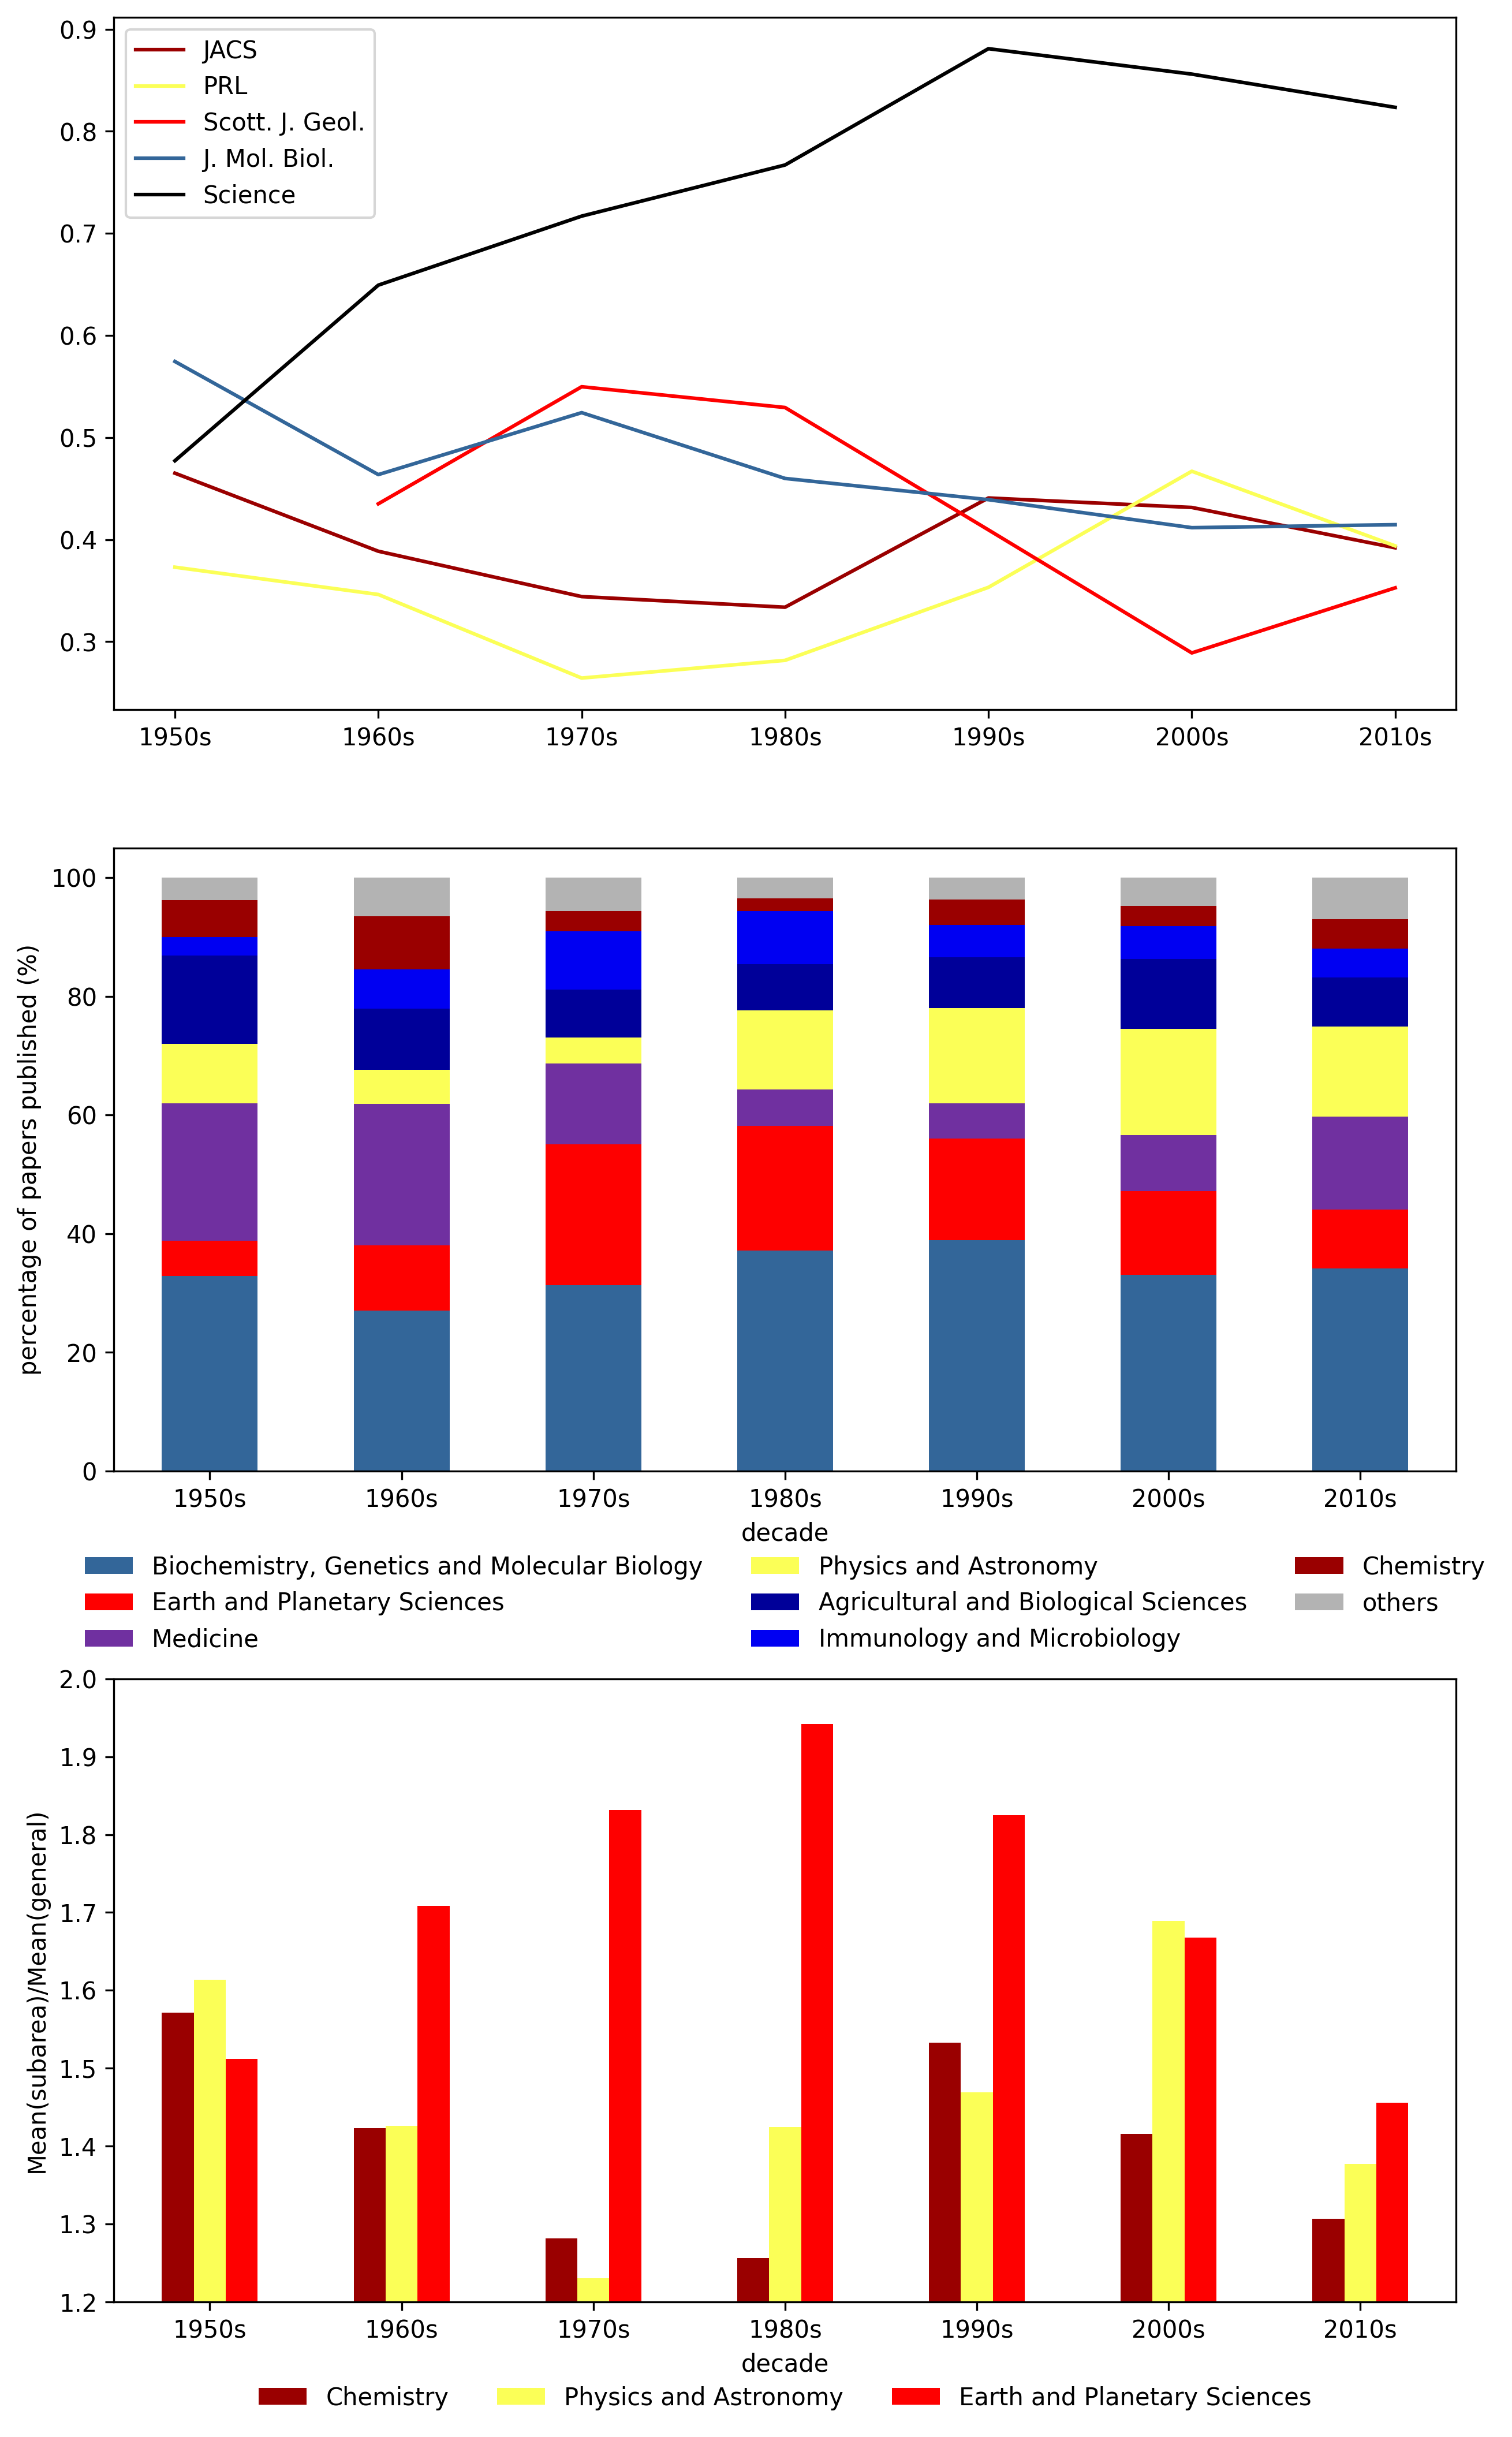

In [71]:
fig = plt.figure(figsize=(10,18), dpi=300)

plt.subplot(3,1,1)
jnl_color_dict = {
    'Science': '#000000',
    'J. Mol. Biol.': '#336699',
    'PRL': '#FBFF57',
    'Scott. J. Geol.': '#FE0000',
    'JACS': '#9A0000'
}
jnl_abbr_dict = {
    'Science': 'Science',
    'Journal of Molecular Biology': 'J. Mol. Biol.',
    'Physical Review Letters': 'PRL',
    'Scottish Journal of Geology': 'Scott. J. Geol.',
    'Journal of the American Chemical Society': 'JACS'
}
jnl_cs_df.rename(columns=jnl_abbr_dict, inplace=True)
sns.lineplot(jnl_cs_df, palette=jnl_color_dict, dashes=False)

plt.subplot(3,1,2)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(3,1,3)
ax_cs = cs_df[['Chemistry',
               'Physics and Astronomy', 
               'Earth and Planetary Sciences']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(1.2, 2.0)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [73]:
fig.savefig('Nature.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False)

# Science

In [22]:
count_df = count_paper_num_for_disc(3880285)

2023-08-16 17:48:07 -- start searching in 1950 to 1959
2023-08-16 17:48:07 -- start loading VID_labeled...
2023-08-16 17:48:07 -- finish.
2023-08-16 17:48:08 -- start searching in 1960 to 1969
2023-08-16 17:48:08 -- start loading VID_labeled...
2023-08-16 17:48:08 -- finish.
2023-08-16 17:48:10 -- start searching in 1970 to 1979
2023-08-16 17:48:10 -- start loading VID_labeled...
2023-08-16 17:48:10 -- finish.
2023-08-16 17:48:12 -- start searching in 1980 to 1989
2023-08-16 17:48:13 -- start loading VID_labeled...
2023-08-16 17:48:13 -- finish.
2023-08-16 17:48:17 -- start searching in 1990 to 1999
2023-08-16 17:48:17 -- start loading VID_labeled...
2023-08-16 17:48:17 -- finish.
2023-08-16 17:48:24 -- start searching in 2000 to 2009
2023-08-16 17:48:25 -- start loading VID_labeled...
2023-08-16 17:48:25 -- finish.
2023-08-16 17:48:40 -- start searching in 2010 to 2021
2023-08-16 17:48:43 -- start loading VID_labeled...
2023-08-16 17:48:43 -- finish.


/tmp/ipykernel_1098832/2634740842.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_df_full = count_df_up.append({'index': 'others',


In [23]:
cs_df = cal_disc_avg_cs(3880285)

2023-08-16 17:49:21 -- start loading word vectors...
2023-08-16 17:49:21 -- word vectors loaded, and its shape is: (1683, 100)
2023-08-16 17:49:21 -- start loading VID_labeled...
2023-08-16 17:49:21 -- finish.
2023-08-16 17:49:21 -- start loading word vectors...
2023-08-16 17:49:21 -- word vectors loaded, and its shape is: (3186, 100)
2023-08-16 17:49:21 -- start loading VID_labeled...
2023-08-16 17:49:21 -- finish.
2023-08-16 17:49:21 -- start loading word vectors...
2023-08-16 17:49:21 -- word vectors loaded, and its shape is: (5761, 100)
2023-08-16 17:49:21 -- start loading VID_labeled...
2023-08-16 17:49:21 -- finish.
2023-08-16 17:49:21 -- start loading word vectors...
2023-08-16 17:49:21 -- word vectors loaded, and its shape is: (9437, 100)
2023-08-16 17:49:21 -- start loading VID_labeled...
2023-08-16 17:49:21 -- finish.
2023-08-16 17:49:21 -- start loading word vectors...
2023-08-16 17:49:21 -- word vectors loaded, and its shape is: (15153, 100)
2023-08-16 17:49:21 -- start loa

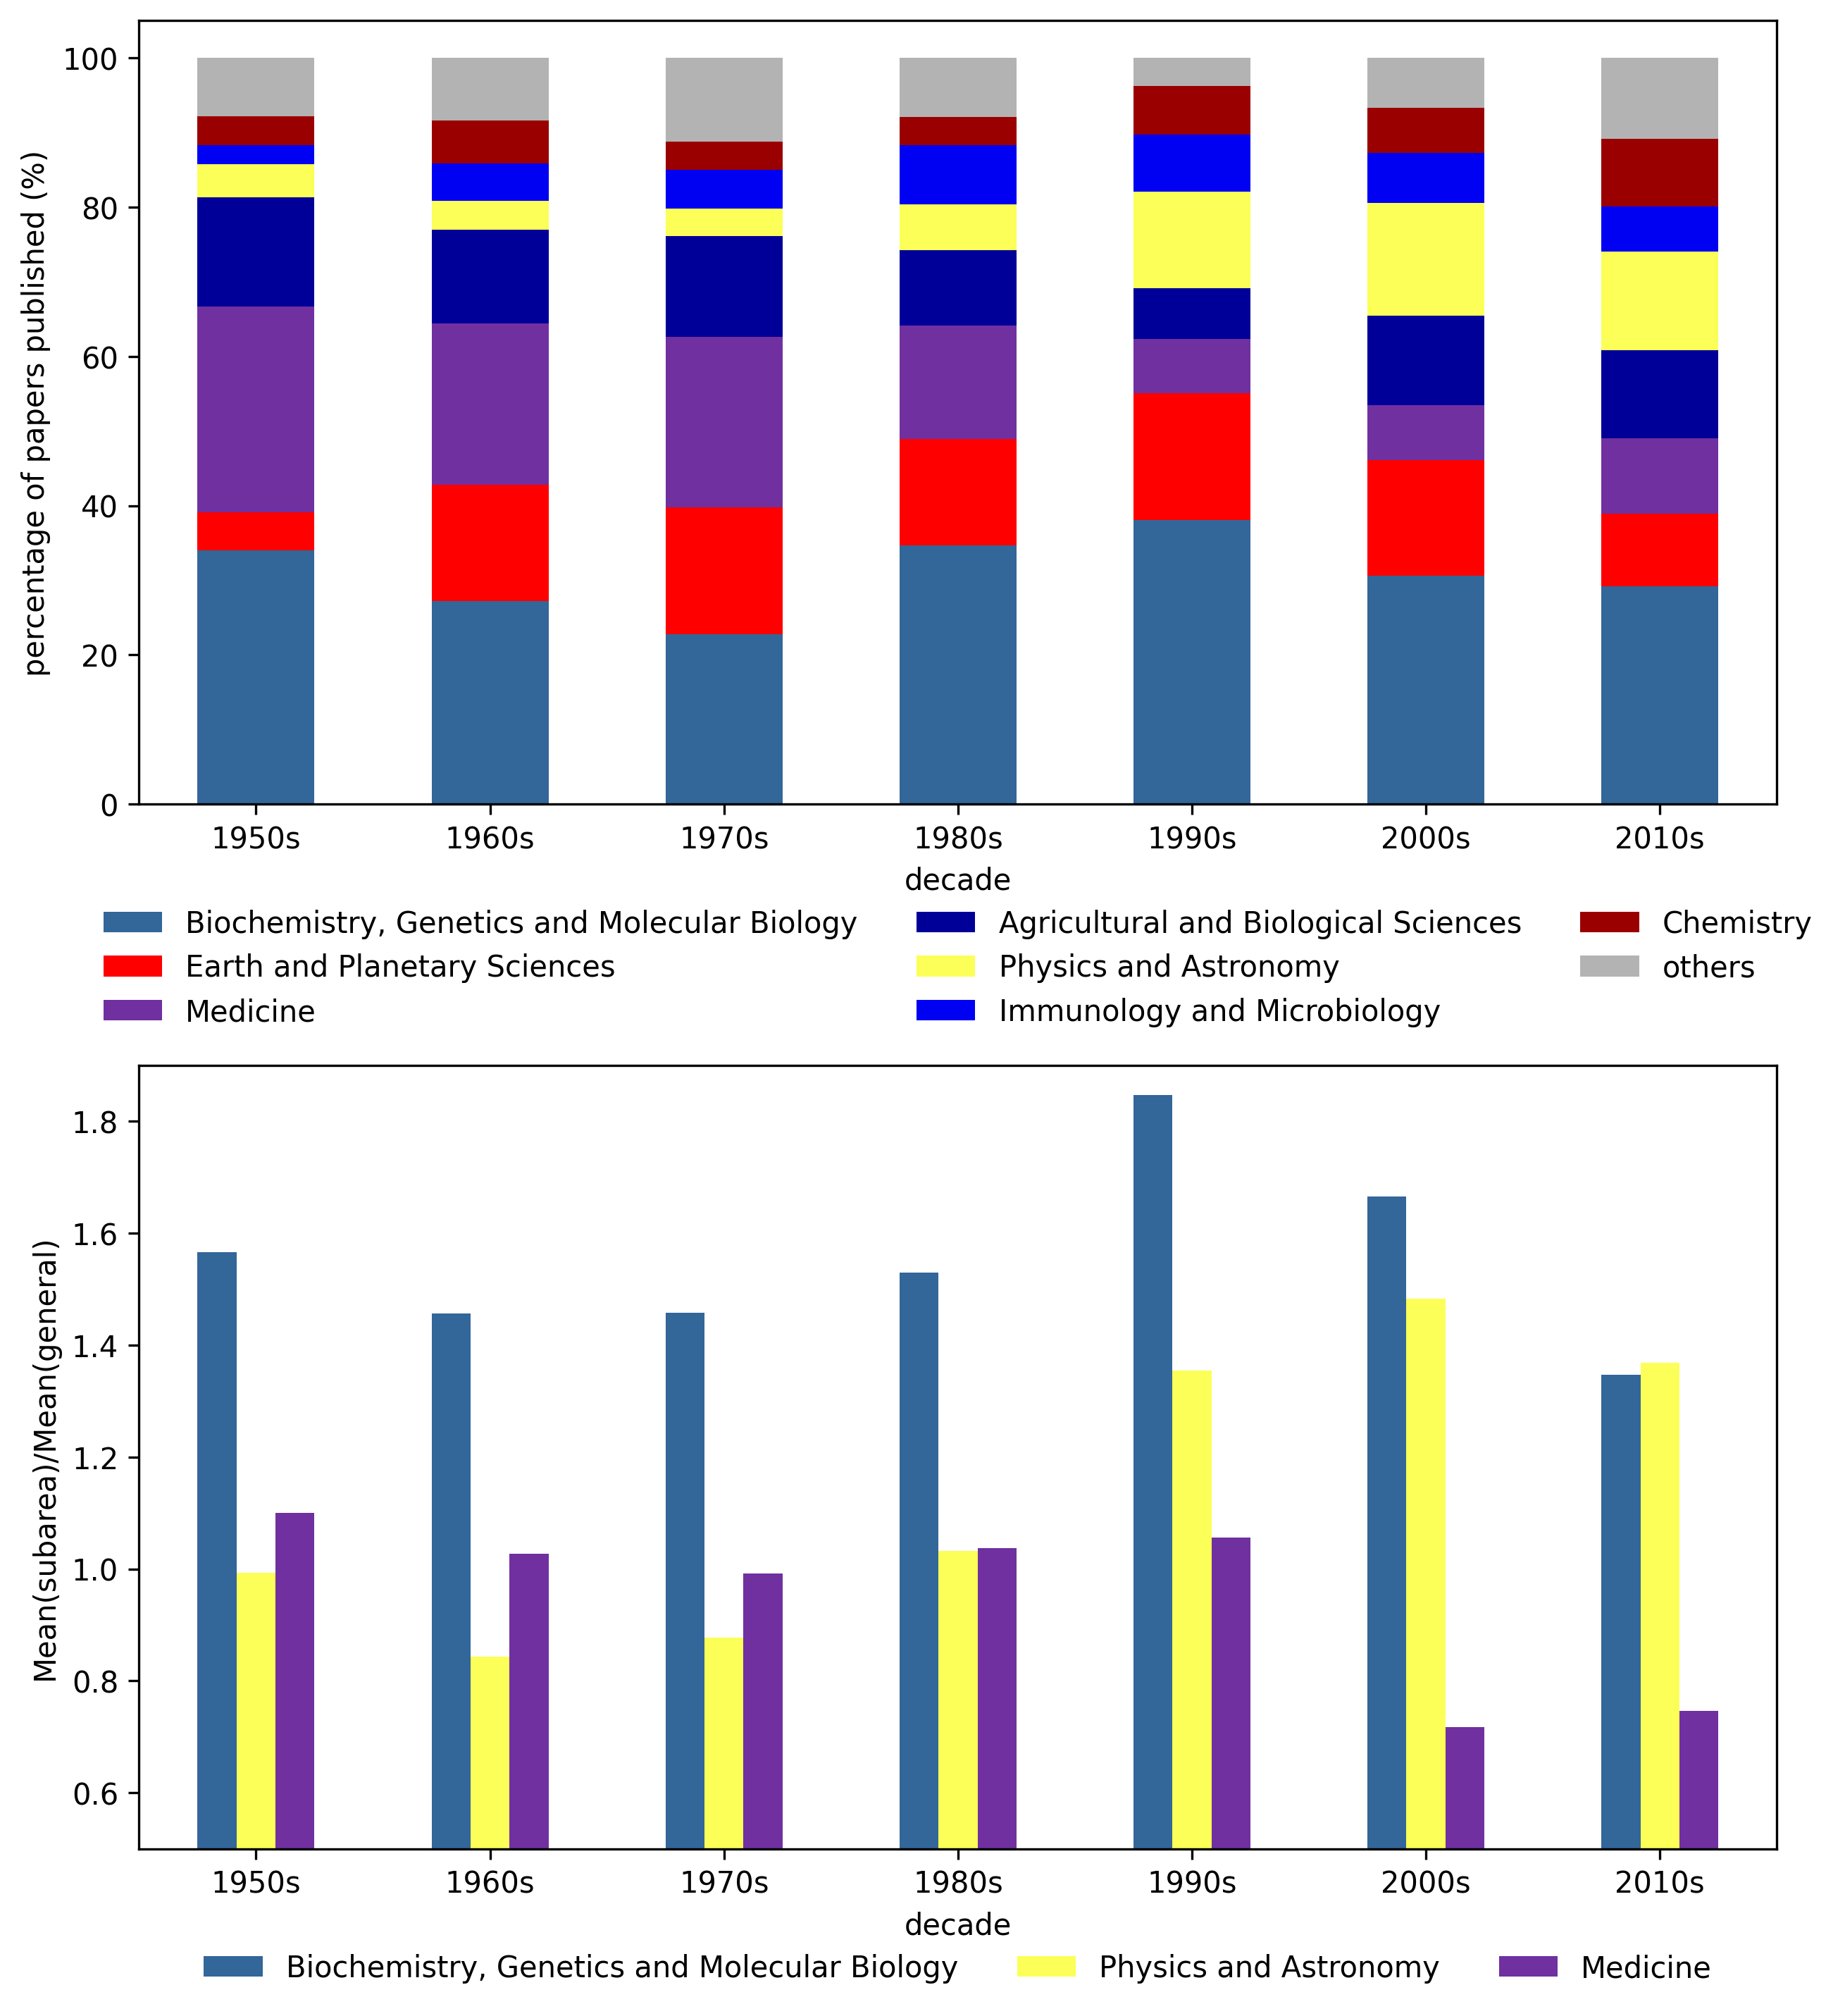

In [26]:
fig = plt.figure(figsize=(10,12), dpi=300)

plt.subplot(2,1,1)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(2,1,2)
ax_cs = cs_df[['Biochemistry, Genetics and Molecular Biology',
               'Physics and Astronomy', 
               'Medicine']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(0.5, 1.9)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [27]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/Science.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

In [28]:
count_df = count_paper_num_for_disc(125754415)

2023-08-16 17:51:53 -- start searching in 1950 to 1959
2023-08-16 17:51:53 -- start loading VID_labeled...
2023-08-16 17:51:53 -- finish.
2023-08-16 17:51:53 -- start searching in 1960 to 1969
2023-08-16 17:51:53 -- start loading VID_labeled...
2023-08-16 17:51:53 -- finish.
2023-08-16 17:51:54 -- start searching in 1970 to 1979
2023-08-16 17:51:54 -- start loading VID_labeled...
2023-08-16 17:51:54 -- finish.
2023-08-16 17:51:56 -- start searching in 1980 to 1989
2023-08-16 17:51:57 -- start loading VID_labeled...
2023-08-16 17:51:57 -- finish.
2023-08-16 17:52:01 -- start searching in 1990 to 1999
2023-08-16 17:52:01 -- start loading VID_labeled...
2023-08-16 17:52:01 -- finish.
2023-08-16 17:52:09 -- start searching in 2000 to 2009
2023-08-16 17:52:10 -- start loading VID_labeled...
2023-08-16 17:52:10 -- finish.
2023-08-16 17:52:27 -- start searching in 2010 to 2021
2023-08-16 17:52:29 -- start loading VID_labeled...
2023-08-16 17:52:29 -- finish.


/tmp/ipykernel_1098832/2634740842.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_df_full = count_df_up.append({'index': 'others',


In [29]:
cs_df = cal_disc_avg_cs(125754415)

2023-08-16 17:53:08 -- start loading word vectors...
2023-08-16 17:53:08 -- word vectors loaded, and its shape is: (1683, 100)
2023-08-16 17:53:08 -- start loading VID_labeled...
2023-08-16 17:53:08 -- finish.
2023-08-16 17:53:08 -- start loading word vectors...
2023-08-16 17:53:08 -- word vectors loaded, and its shape is: (3186, 100)
2023-08-16 17:53:08 -- start loading VID_labeled...
2023-08-16 17:53:08 -- finish.
2023-08-16 17:53:09 -- start loading word vectors...
2023-08-16 17:53:09 -- word vectors loaded, and its shape is: (5761, 100)
2023-08-16 17:53:09 -- start loading VID_labeled...
2023-08-16 17:53:09 -- finish.
2023-08-16 17:53:09 -- start loading word vectors...
2023-08-16 17:53:09 -- word vectors loaded, and its shape is: (9437, 100)
2023-08-16 17:53:09 -- start loading VID_labeled...
2023-08-16 17:53:09 -- finish.
2023-08-16 17:53:09 -- start loading word vectors...
2023-08-16 17:53:09 -- word vectors loaded, and its shape is: (15153, 100)
2023-08-16 17:53:09 -- start loa

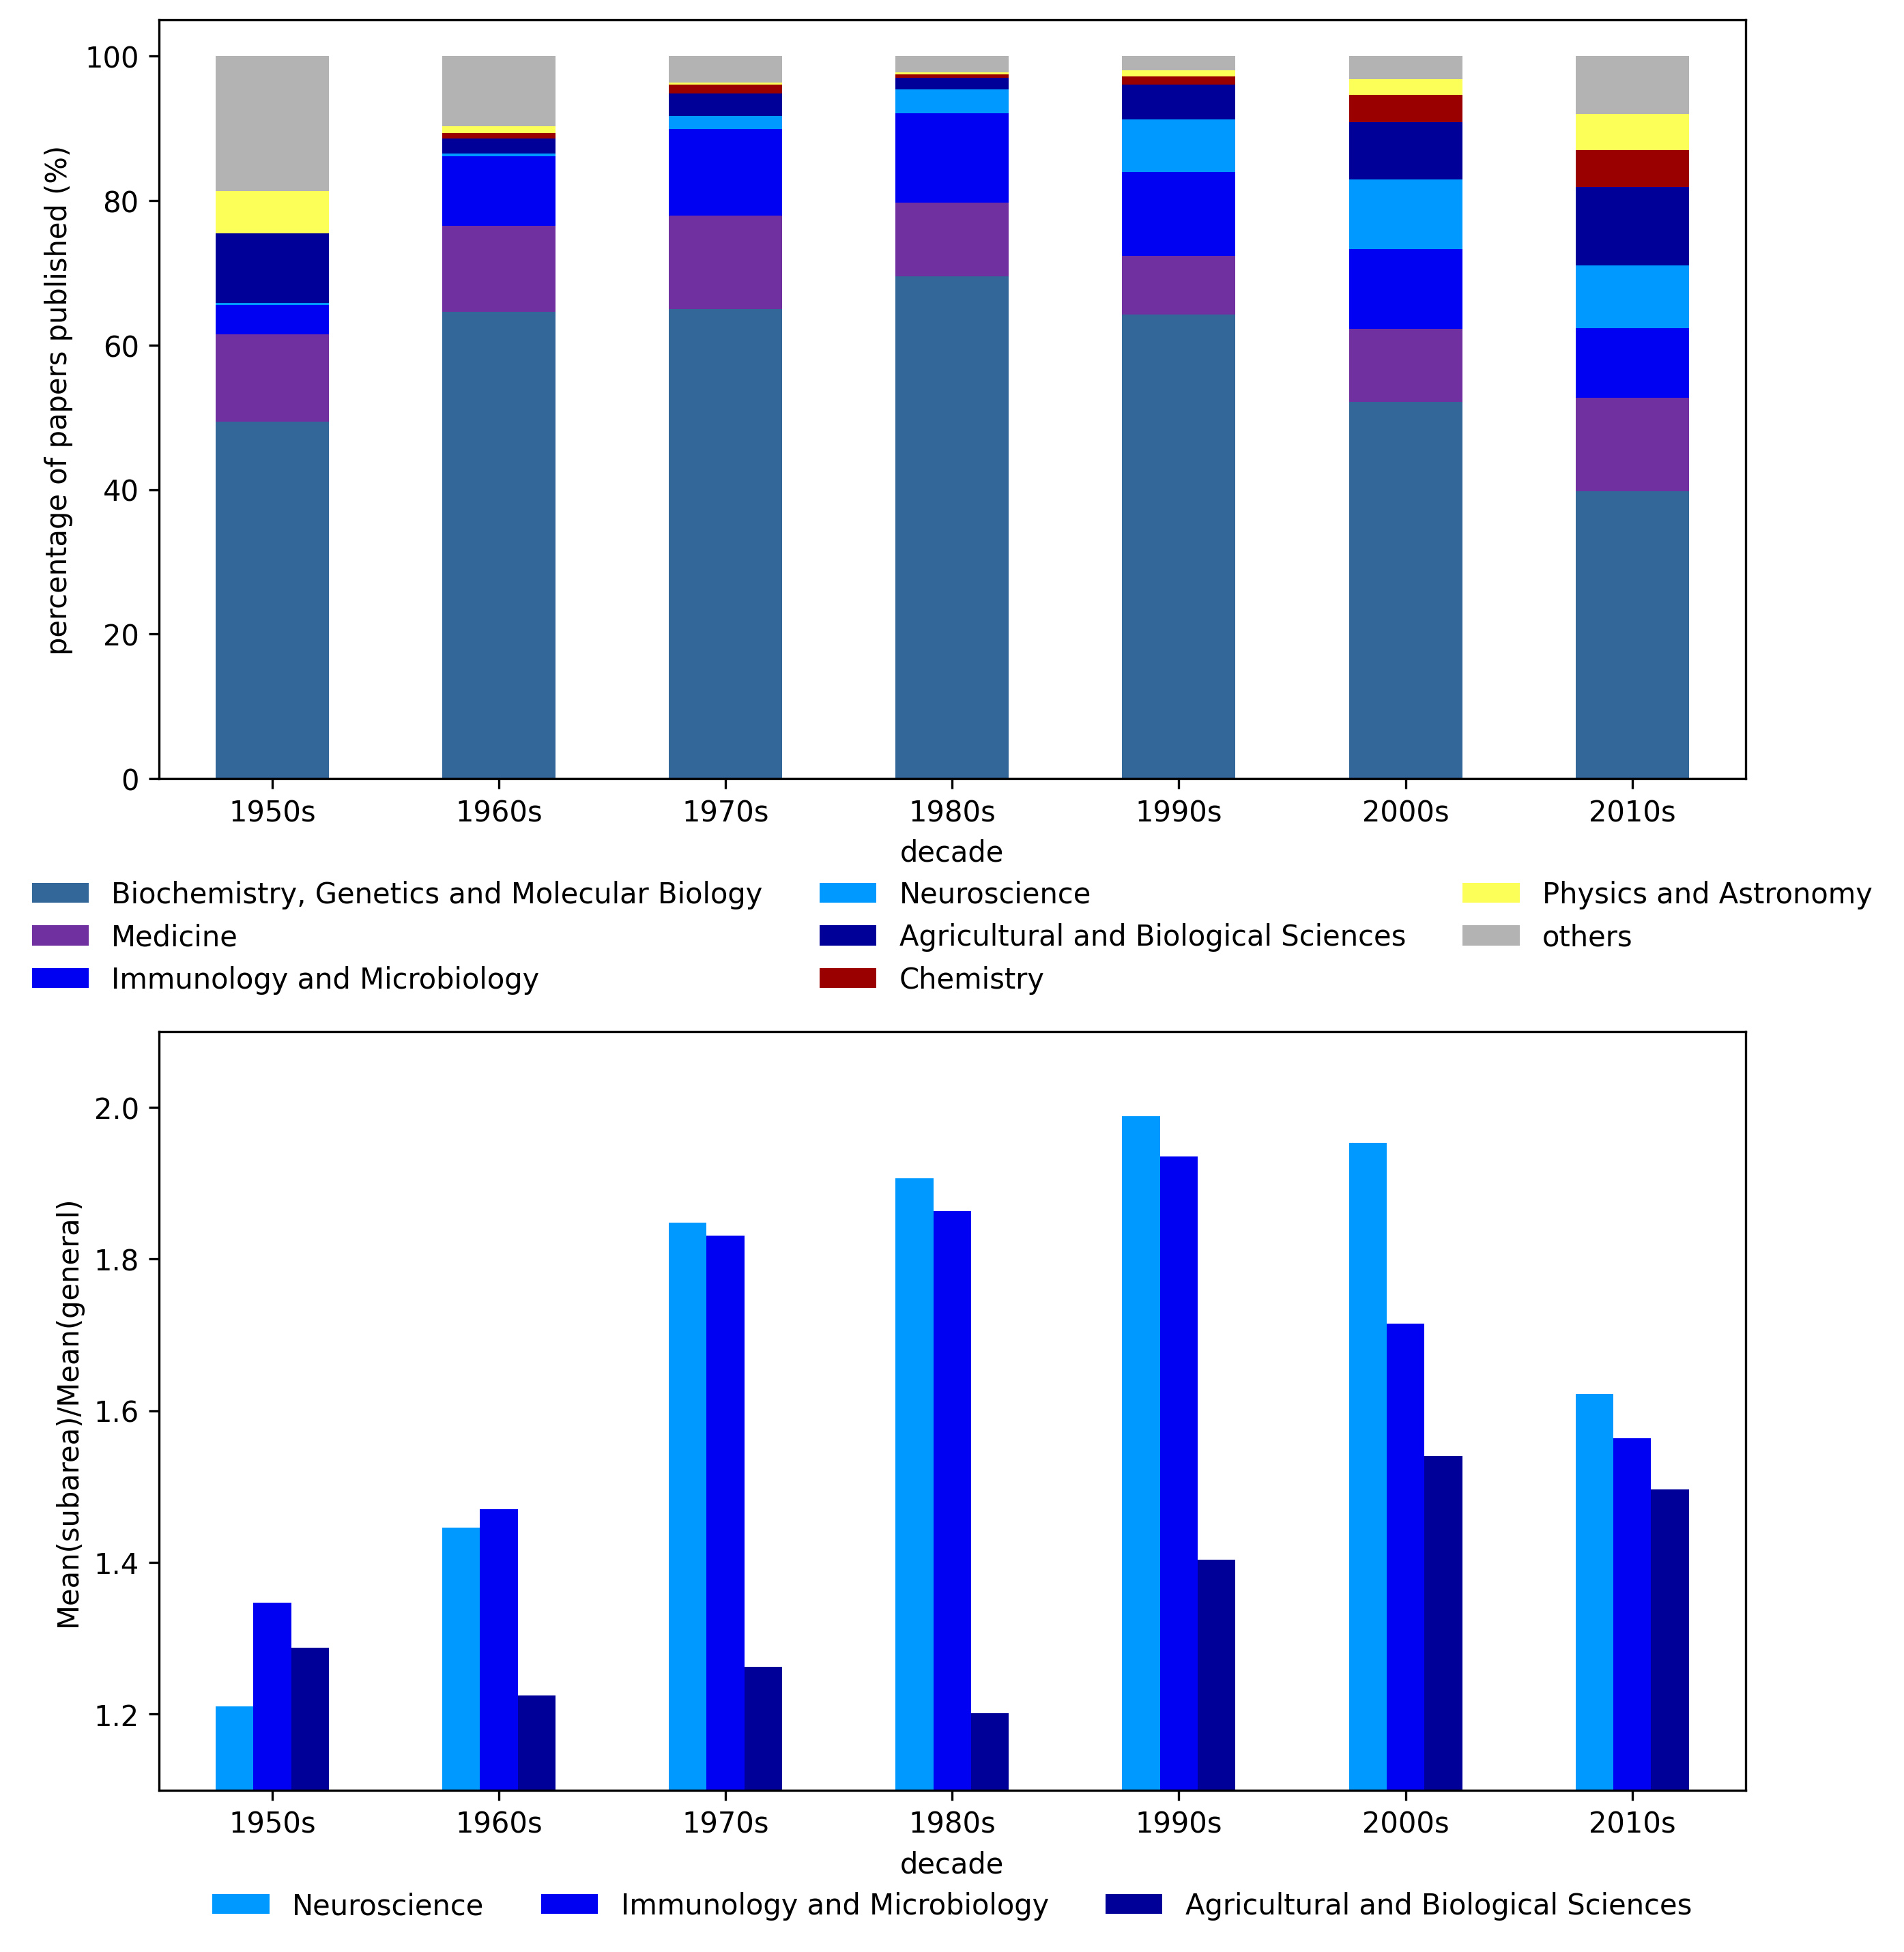

In [33]:
fig = plt.figure(figsize=(10,12), dpi=300)

plt.subplot(2,1,1)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(2,1,2)
ax_cs = cs_df[['Neuroscience',
               'Immunology and Microbiology', 
               'Agricultural and Biological Sciences']].plot(kind ='bar', ax=plt.gca(), 
                                          xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                          color=color_dict)
ax_cs.set_ylim(1.1, 2.1)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [34]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
fig.savefig('/media/sdb/p2v/figs/PNAS.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')